In [8]:
%matplotlib notebook
import numpy as np
import matplotlib
from astropy.table import Table, vstack, join
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotting_resources as res
import matplotlib.gridspec as gs
plt.rc('text', usetex=True)
plt.ion()

rauto_cut = 22.9
frauto_cut = 10**((rauto_cut-23.9)/(-2.5))

In [2]:
cluster_args = {'markersize': 5, 'color': 'w', 'markeredgecolor': 'k', 'markeredgewidth': 0.4}
binned_args = {'markersize': 7, 'fmt':'ok', 'capsize': 3, 'elinewidth': 0.5, 'capthick': 0.5}
overall_args = {'linestyle': '--', 'color':'k', 'linewidth':0.5}

# Load the catalogs

In [3]:
slitcat = Table().read('../catalogs/personal_catalogs/slits_phot_zs_cutonslitdist_rcl.csv', format='csv')
ldpcat = slitcat[np.where((slitcat['Rauto'] < rauto_cut) & 
                          (slitcat['Q'] >= 4) & 
                          (slitcat['slit_distance'] < 1.0))]
cltable = res.load_clusters()
rfmags = Table().read('../catalogs/eazy_colors/ediscs_zldp_zfors_EAzY_outputs.csv', format='csv')
rfmags.rename_column('id', 'ids')

ldpcat = join(ldpcat, rfmags['ids','MAG_AB_rfB', 'MAG_AB_rfU'], keys='ids', join_type='left')
ldpcat['UB_color'] = ldpcat['MAG_AB_rfU'] - ldpcat['MAG_AB_rfB']

# For each cluster, calculate the red fraction in the cluster region and infall regions

In [4]:
def calc_red_frac(red, blue):
    if len(red)+len(blue) == 0:
        redfrac = 0.0
        upper, lower = 0.0, 0.0
    else:
        nred = float(len(red))
        nblue = float(len(blue))
        ntot = nred+nblue
        
        redfrac = nred/(ntot)
        upper = np.sqrt((res.upper_limit(nred)-nred)**2*(1./ntot - nred/ntot**2)**2 + 
                        (res.upper_limit(nblue)-nblue)**2*(nred/ntot**2)**2)
        lower = np.sqrt((nred-res.lower_limit(nred))**2*(1./ntot - nred/ntot**2)**2 + 
                        (nblue-res.upper_limit(nblue))**2*(nred/ntot**2)**2)    
        
    return redfrac, upper, lower

In [5]:
overall_cluster_red, overall_cluster_blue = Table(), Table() 
overall_infall_red, overall_infall_blue = Table(), Table()

cltable['redfrac_cluster'] = 0.0
cltable['redfrac_infall'] = 0.0
for cl in cltable:
    subcat = ldpcat[np.where((ldpcat['field'] == cl['tablename']) &
                             (abs(ldpcat['zLDP'] - cl['z']) < 0.02))]
    cluster_region = subcat[np.where(subcat['d_cl_mpc'] < cl['r200'])]
    infall_region = subcat[np.where((subcat['d_cl_mpc'] > cl['r200']) & (subcat['d_cl_mpc'] < cl['rinfall']))]
    
    red, blue = res.add_red_blue(cluster_region, cl)
    redfrac_cluster, _, _ = calc_red_frac(red, blue)
    overall_cluster_red = vstack([overall_cluster_red, red])
    overall_cluster_blue = vstack([overall_cluster_blue, blue])
    
    red, blue = res.add_red_blue(infall_region, cl)
    redfrac_infall, _, _ = calc_red_frac(red, blue)
    overall_infall_red = vstack([overall_infall_red, red])
    overall_infall_blue = vstack([overall_infall_blue, blue])
    
    cl['redfrac_cluster'] = redfrac_cluster
    cl['redfrac_infall'] = redfrac_infall
    
rf_cl_overall, rf_cl_overall_upper, rf_cl_overall_lower = calc_red_frac(overall_cluster_red, overall_cluster_blue)
rf_in_overall, rf_in_overall_upper, rf_in_overall_lower = calc_red_frac(overall_infall_red, overall_infall_blue)

/Users/matthewkirby/galaxy_evolution/just2017plots/plotting_resources.py:23: RuntimeWarning: invalid value encountered in sqrt
  return n - s*np.sqrt(n - 0.25) + 0.25*(s*s - 1.)
/Users/matthewkirby/galaxy_evolution/just2017plots/plotting_resources.py:23: RuntimeWarning: invalid value encountered in sqrt
  return n - s*np.sqrt(n - 0.25) + 0.25*(s*s - 1.)


# Calculate the red fraction in sigma bins of width 500 km s$^{-1}$

In [6]:
sigma_bins = [0., 500., 1000., 1500.]

binned_redfrac_cluster = []
binned_redfrac_cluster_upper = []
binned_redfrac_cluster_lower = []

binned_redfrac_infall = []
binned_redfrac_infall_upper = []
binned_redfrac_infall_lower = []

for i in range(1, 4):
    subcllist = cltable[np.where((cltable['sigma'] > sigma_bins[i-1]) & (cltable['sigma'] < sigma_bins[i]))]
    cluster, infall = Table(), Table()
    for cl in subcllist:
        subcat = ldpcat[np.where((ldpcat['field'] == cl['tablename']) &
                                 (abs(ldpcat['zLDP'] - cl['z']) < 0.02))]
        cluster_region = subcat[np.where(subcat['d_cl_mpc'] < cl['r200'])]
        infall_region = subcat[np.where((subcat['d_cl_mpc'] > cl['r200']) & (subcat['d_cl_mpc'] < cl['rinfall']))]
        cluster = vstack([cluster, cluster_region])
        infall = vstack([infall, infall_region])
    
    red, blue = res.add_red_blue(cluster, cl)
    redfrac_cluster, rf_cl_upper, rf_cl_lower = calc_red_frac(red, blue)
    red, blue = res.add_red_blue(infall, cl)
    redfrac_infall, rf_in_upper, rf_in_lower = calc_red_frac(red, blue)
    
    binned_redfrac_cluster.append(redfrac_cluster)
    binned_redfrac_cluster_upper.append(rf_cl_upper)
    binned_redfrac_cluster_lower.append(rf_cl_lower)
    
    binned_redfrac_infall.append(redfrac_infall)
    binned_redfrac_infall_upper.append(rf_in_upper)
    binned_redfrac_infall_lower.append(rf_in_lower)

# Calculate the field fraction

In [7]:
# Chose clusters to use
cltable.sort('z')
fieldcls = cltable[0:1]

for cl in cltable:
    if cl['z'] > fieldcls['z'][-1] + 0.04:
        fieldcls.add_row(cl)
        
# Build the catalogs
fieldsample = Table()
for cl in fieldcls:
    subtable = ldpcat[np.where((ldpcat['field'] == cl['tablename']) &
                               (abs(ldpcat['zLDP']-cl['z']) > 0.02))]
    fieldsample = vstack([fieldsample, subtable])

# Split into red and blue
fieldred, fieldblue = Table(), Table()
for cl in fieldcls:
    subtable = fieldsample[np.where(abs(fieldsample['zLDP']-cl['z']) < 0.02)]
    red, blue = res.add_red_blue(subtable, cl)
    fieldred = vstack([fieldred, red])
    fieldblue = vstack([fieldblue, blue])

# Calculate the red fraction for the field
redfraction_field, field_upper, field_lower = calc_red_frac(fieldred, fieldblue)

# Build the plots

<IPython.core.display.Javascript object>


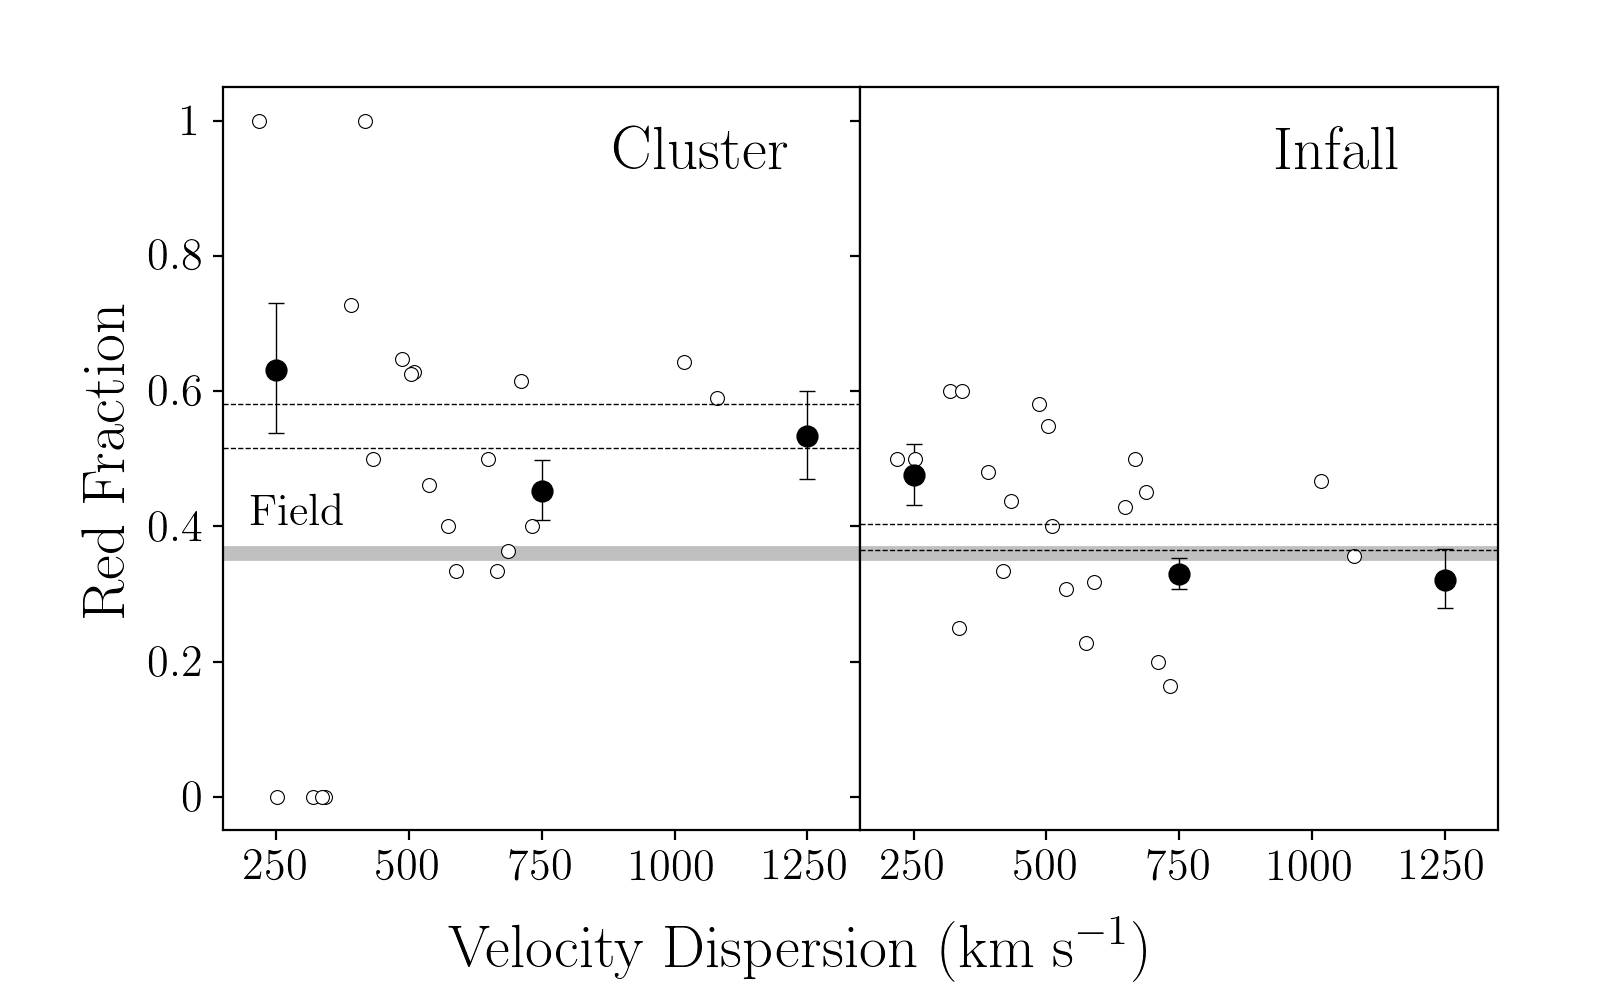

In [9]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(8, 5))
outer = gs.GridSpec(1, 2, wspace=0)
fig.text(0.5, 0.05, r'Velocity Dispersion (km s$^{-1}$)', ha='center', va='center')


#ax = fig.add_subplot(111)
#ax.spines['top'].set_color('w')
#ax.spines['bottom'].set_color('w')
#ax.spines['left'].set_color('w')
#ax.spines['right'].set_color('w')
#ax.tick_params(labelcolor='k', top='off', bottom='off', left='off', right='off')

a1 = plt.subplot(outer[0])
a2 = plt.subplot(outer[1])

a1.set_ylabel(r'Red Fraction')


plt.tight_layout(rect=[0, .03, 1, 1])

In [10]:
# Left plot
a1.fill_between(x=[100, 1500],
                y1=[redfraction_field+field_upper, redfraction_field+field_upper],
                y2=[redfraction_field-field_lower, redfraction_field-field_lower],
                color='silver', label=None)
a1.plot(cltable['sigma'], cltable['redfrac_cluster'], 'ok', label='x', **cluster_args);
a1.errorbar(np.diff(sigma_bins)*0.5+sigma_bins[:3], binned_redfrac_cluster, 
            yerr=[binned_redfrac_cluster_lower, binned_redfrac_cluster_upper],
            **binned_args, label=None);

a1.axhline(rf_cl_overall+rf_cl_overall_upper, **overall_args)
a1.axhline(rf_cl_overall-rf_cl_overall_lower, **overall_args)

a1.text(1050, .95, 'Cluster', ha='center', va='center')
a1.text(200, 0.4, 'Field', ha='left', size=16)


a1.set_yticks([0.0, .2, .4, .6, .8, 1.0])
a1.set_yticklabels([0, .2, .4, .6, .8, 1], fontsize=16)
a1.set_xticks([250, 500, 750, 1000, 1250])
a1.set_xticklabels([250, 500, 750, 1000, 1250], fontsize=16)

a1.set_ylim(-0.05, 1.05)
a1.set_xlim(150, 1350)

(150, 1350)

In [11]:
a2.fill_between(x=[100, 1500],
                y1=[redfraction_field+field_upper, redfraction_field+field_upper],
                y2=[redfraction_field-field_lower, redfraction_field-field_lower],
                color='silver')
a2.plot(cltable['sigma'], cltable['redfrac_infall'], 'ok', **cluster_args);
a2.errorbar(np.diff(sigma_bins)*0.5+sigma_bins[:3], binned_redfrac_infall, 
            yerr=[binned_redfrac_infall_lower, binned_redfrac_infall_upper],
            **binned_args);

a2.axhline(rf_in_overall+rf_in_overall_upper, **overall_args)
a2.axhline(rf_in_overall-rf_in_overall_lower, **overall_args)

a2.text(1050, .95, 'Infall', ha='center', va='center')

a2.set_xticks([250, 500, 750, 1000, 1250])
a2.set_xticklabels([250, 500, 750, 1000, 1250], fontsize=16)
a2.set_yticklabels([]);


a2.set_ylim(-0.05, 1.05)
a2.set_xlim(150, 1350)

(150, 1350)

In [11]:
plt.savefig('plots/red_fraction_sigma.eps', dpi=800)

# Calculate the elevations of red galaxies between field, infall and core

In [16]:
# Field
rf_f = redfraction_field
rfe_f = (field_upper + field_lower)/2.
# Core
rf_c = rf_cl_overall
rfe_c = (rf_cl_overall_upper + rf_cl_overall_lower)/2.
# Infall
rf_i = rf_in_overall
rfe_i = (rf_in_overall_upper + rf_in_overall_lower)/2.

In [26]:
# Core over Infall
tci = np.sqrt(rfe_i**2 + rfe_c**2)
print("Core is elevated over infall by {}sigma".format((rf_c-rf_i)/tci))
# Core over Field
tcf = np.sqrt(rfe_c**2 + rfe_f**2)
print("Core is elevated over field by {}sigma".format((rf_c-rf_f)/tcf))
# Infall over field (although they are consistent)
tif = np.sqrt(rfe_i**2 + rfe_f**2)
print("Infall is elevated over field by {}sigma".format((rf_i-rf_f)/tif))

Core is elevated over infall by 4.315284862665857sigma
Core is elevated over field by 5.454675081709325sigma
Infall is elevated over field by 1.112716433544654sigma
